In [1]:
import torch
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import horovod.torch as hvd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hvd.init()
torch.cuda.set_device(hvd.local_rank())

In [2]:
train_data = MNIST(
    root="/data/DataSet/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)

test_data = MNIST(
    root="/data/DataSet/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)

train_sampler = DistributedSampler(
    train_data,
    num_replicas=hvd.size(),
    rank=hvd.rank()
)

test_sampler = DistributedSampler(
    test_data,
    num_replicas=hvd.size(),
    rank=hvd.rank()
)

print(f"Training image shape: {train_data[0][0].shape}")

batch_size = 10000

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    num_workers=4,
    sampler=train_sampler
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=4,
    sampler=test_sampler
)

dataloader_dict = {"train" : train_loader, "test": test_loader}

Training image shape: torch.Size([1, 32, 32])


In [3]:
labels_map = train_data.class_to_idx
labels_map = dict(zip(labels_map.values(), labels_map.keys()))

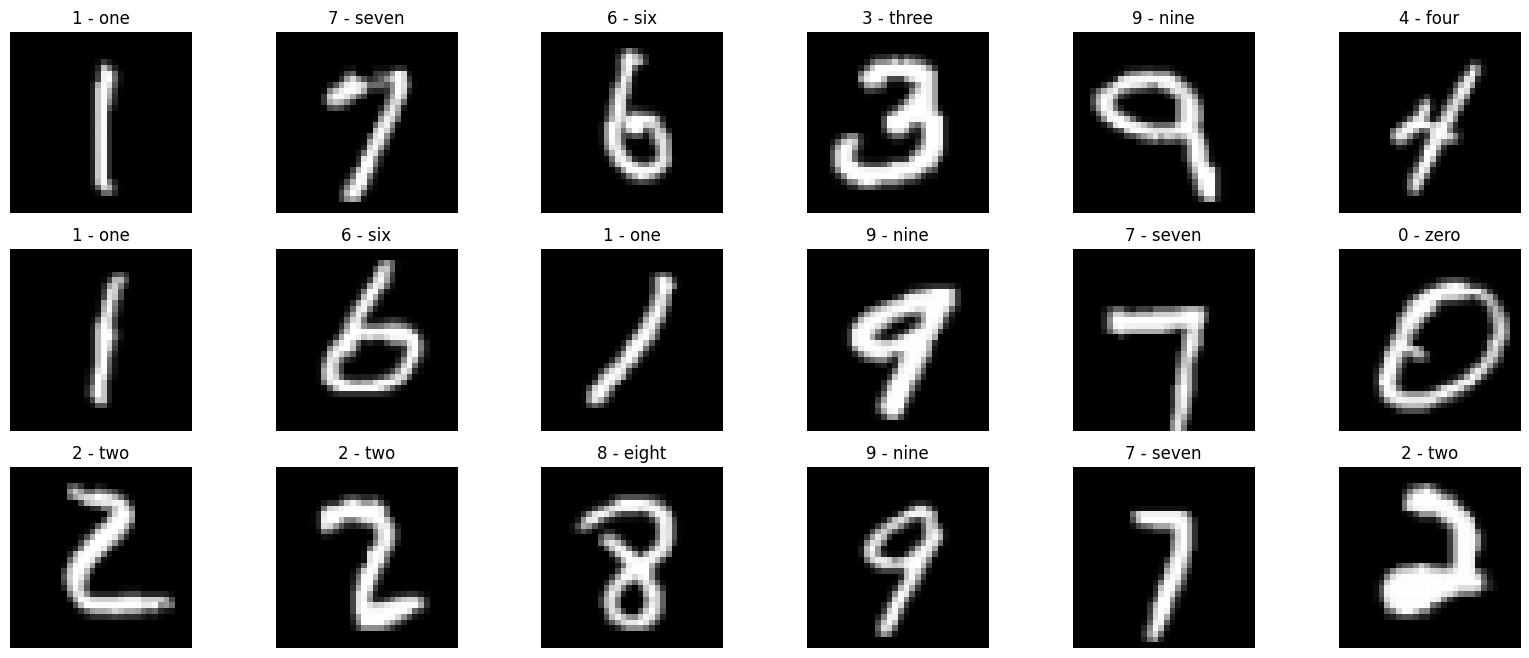

In [4]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]

    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')

plt.show()

In [5]:
class linear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(linear, self).__init__()

        layers = [
            nn.Linear(
                in_features=in_features,
                out_features=out_features
            )
        ]

        if normalize:
            layers.append(
                nn.BatchNorm1d(
                    num_features=out_features
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class conv(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5, 
        stride: int = 1, 
        padding: int = 0,
        normalize: bool = True,
        activation: bool = True,
        m_pool: int = 2
        ):

        super(conv, self).__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
        ]
        
        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_channels
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if m_pool:
            layers.append(
                nn.MaxPool2d(
                    kernel_size=2
                )
            )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
        
class LeNet5(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super(LeNet5, self).__init__()
        
        # 32 -> 14
        self.layer1 = conv(
            in_channels=1,
            out_channels=6,
            m_pool=2
        )
        
        # 14 -> 5
        self.layer2 = conv(
            in_channels=6,
            out_channels=16,
            m_pool=2
        )

        # 400 -> 120
        self.layer3 = linear(
            in_features=400,
            out_features=120,
        )

        # 120 -> 84
        self.layer4 = linear(
            in_features=120,
            out_features=84
        )
        
        # 84 -> 10
        self.layer5 = nn.Sequential(
            nn.Linear(
                in_features=84,
                out_features=10
            ),
            nn.Softmax(
                dim=1
            )
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 16*5*5)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return self.layer5(x)

In [9]:
num_epochs = 200

model = LeNet5()

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = hvd.DistributedOptimizer(
    optimizer=optimizer,
    named_parameters=model.named_parameters()
)

criterion = nn.CrossEntropyLoss().to(device)
hvd.broadcast_parameters(
    model.state_dict(),
    root_rank=0
)

# writer = SummaryWriter("Tensorboard/")

for epoch in tqdm(range(1, num_epochs + 1)):

    for phase in ['train', 'test']:
        if phase == "train":
            model.train()
        elif phase == "test":
            model.eval()
        
        for imgs, labels in dataloader_dict[phase]:
            x, y = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
         
            with torch.set_grad_enabled(phase == "train"):
                y_hat = model(x)
                _, preds = torch.max(y_hat, 1)
                loss = criterion(y_hat, y)
                print(y.shape)
                print(y_hat.shape)
                # writer.add_scalar("Loss/train", loss, epoch)

                # if phase == "train":
                #     loss.backward()
                #     optimizer.step()
            break
        break
    break

# writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([10000])
torch.Size([10000, 10])
torch.Size([10000])


  0%|          | 0/200 [00:04<?, ?it/s]
